In [29]:
import numpy as np


def qthist(x, y, N=5, thresh=4, rng=[], density=True):
    '''
    Use a simple QuadTree approach to dynamically segment 2D
    data and compute a histogram (counts per bin). Since bin
    sizes are variable, by default the histogram returns the
    density (counts/area).

    QuadTree algorithm is implemented with `np.histogram2d`.

    Parameters
    ----------
    x, y : the 2 arrays of data to compute the histogram of
    N : int, optional, default = 5
        the number of levels to compute the QuadTree. Results
        in a maximum of [2**N, 2**N] bins
    thresh : int, optional, default = 4
        the number of points per bin to allow. Will keep
        segmenting bins until N levels is reached.
    range : the XY range to compute histogram over. Follows
        np.histogram2d convention, shape(2,2), optional.
        ``[[xmin, xmax], [ymin, ymax]]``. If not specified,
        `qthist` will use the XY limits of the data with a
        buffer of 1/4 the minimum bin size on each side.
    density : bool, optional, default = True
        If False, the default, returns the number of samples in each bin.
        If True, returns the probability *density* function at the bin:
        ``num / len(x) / bin_area``.

    Returns
    -------
    num, xmin, xmax, ymin, ymax

    num : the array of number counts or densities per bin
    xmin,xmax,ymin,ymax : the left, right, bottom, top
        edges of each bin

    '''

    # start w/ 2x2 array of False leafs
    Mnext = np.empty((2**1,2**1),dtype='bool')*False

    # the 5 quantities to save in our Tree
    num = np.array([])
    xmin = np.array([])
    xmax = np.array([])
    ymin = np.array([])
    ymax = np.array([])

    # Step thru each level of the Tree
    for k in range(1, N+1):
        if len(rng) == 0:
            dx = (np.nanmax(x) - np.nanmin(x)) / (2**k)
            dy = (np.nanmax(y) - np.nanmin(y)) / (2**k)
            rng = [[np.nanmin(x)-dx/4, np.nanmax(x)+dx/4],
                   [np.nanmin(y)-dy/4, np.nanmax(y)+dy/4]]

        # lazily compute histogram of all data at this level
        H1, xedges1, yedges1 = np.histogram2d(x, y, range=rng, bins=2**k,)

        # any leafs at this level to pick, but NOT previously picked?
        if k<N:
            M1 = (H1 <= thresh)
        if k==N:
            # unless we on the last level, then pick the rest of the leafs
            M1 = ~Mnext

        Mprep = np.empty((2**(k+1),2**(k+1)),dtype='bool')*False

        # check leafs at this level
        for i in range(M1.shape[0]):
            for j in range(M1.shape[1]):
                # up-scale the leaf-picking True/False to next level
                if k<N:
                    Mprep[(i*2):((i+1)*2),(j*2):((j+1)*2)] = M1[i,j] | Mnext[i,j]

                # if newly ready to pick, save 5 values
                if M1[i,j] & ~Mnext[i,j]:
                    num = np.append(num, H1[i,j])
                    xmin = np.append(xmin, xedges1[i])
                    xmax = np.append(xmax, xedges1[i+1])
                    ymin = np.append(ymin, yedges1[j])
                    ymax = np.append(ymax, yedges1[j+1])

        Mnext = Mprep

    if density:
        # following example from np.histogram:
        # result is the value of the probability *density* function at the bin,
        # normalized such that the *integral* over the range is 1
        num = num / ((ymax - ymin) * (xmax - xmin)) / num.sum()

    return num, xmin, xmax, ymin, ymax

In [35]:
# Example usage
np.random.seed(42)
x = np.random.uniform(25, 5, 10000)
np.random.seed(39)
y = np.random.uniform(35, 5, 10000)
num, xmin, xmax, ymin, ymax = qthist(x, y, N=8, thresh=30,density=False )

In [36]:
len(num),len(xmax),len(ymin),len(ymax)

(691, 691, 691, 691)

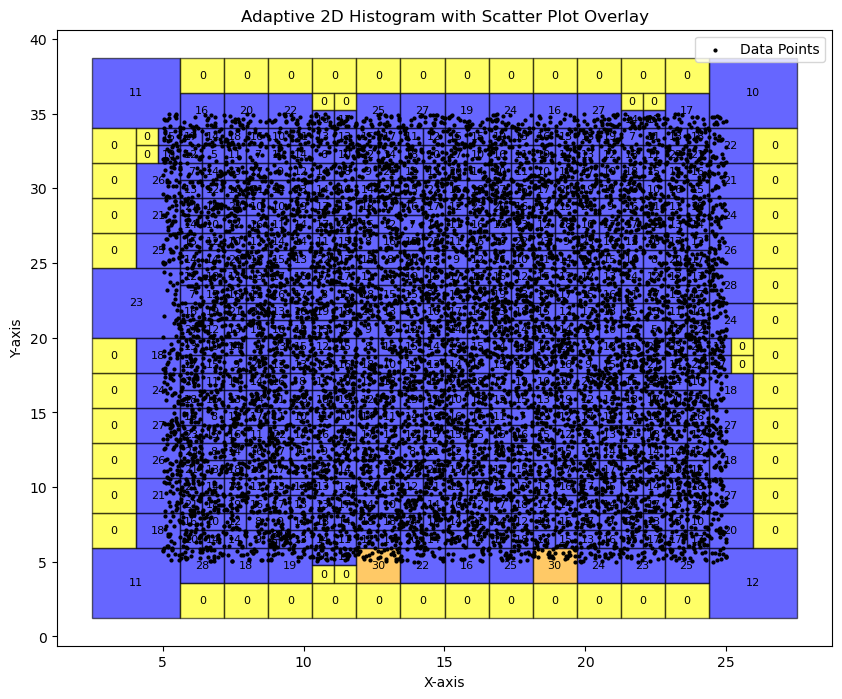

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Scatter plot of data points for reference
# plt.scatter(x, y, color='black', s=4, label='Data Points')
# plt.show()

# Ensure variables are arrays
xmin = np.array(xmin)
xmax = np.array(xmax)
ymin = np.array(ymin)
ymax = np.array(ymax)
num = np.array(num)

# Print debug information
#print("xmin:", xmin, "\nxmax:", xmax, "\nymin:", ymin, "\nymax:", ymax, "\nnum:", num)

# Check that all variables are the same length
assert len(xmin) == len(xmax) == len(ymin) == len(ymax) == len(num), "Array lengths are inconsistent!"

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each bin as a rectangle with color-coding based on counts
for xmin_val, xmax_val, ymin_val, ymax_val, count in zip(xmin, xmax, ymin, ymax, num):
    # Color coding based on count thresholds
    if count == 0:
        color = 'yellow'
    elif count < 30:
        color = 'blue'
#     elif count > 30:
#         color = 'red'
    else:
        color = 'orange'

    # Add a rectangle for each bin
    rect = Rectangle((xmin_val, ymin_val), xmax_val - xmin_val, ymax_val - ymin_val,
                     linewidth=1, edgecolor='black', facecolor=color, alpha=0.6)
    ax.add_patch(rect)

    # Annotate the bin with the count
    ax.text((xmin_val + xmax_val) / 2, (ymin_val + ymax_val) / 2, str(int(count)),
            ha='center', va='center', fontsize=8, color='black')

# Scatter plot of the data points
ax.scatter(x, y, color='black', s=4, label='Data Points')

# Set up labels and title
ax.set_title("Adaptive 2D Histogram with Scatter Plot Overlay")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.legend()
# plt.xlim([x.min(), x.max()])
# plt.ylim([y.min(), y.max()])
# plt.show()


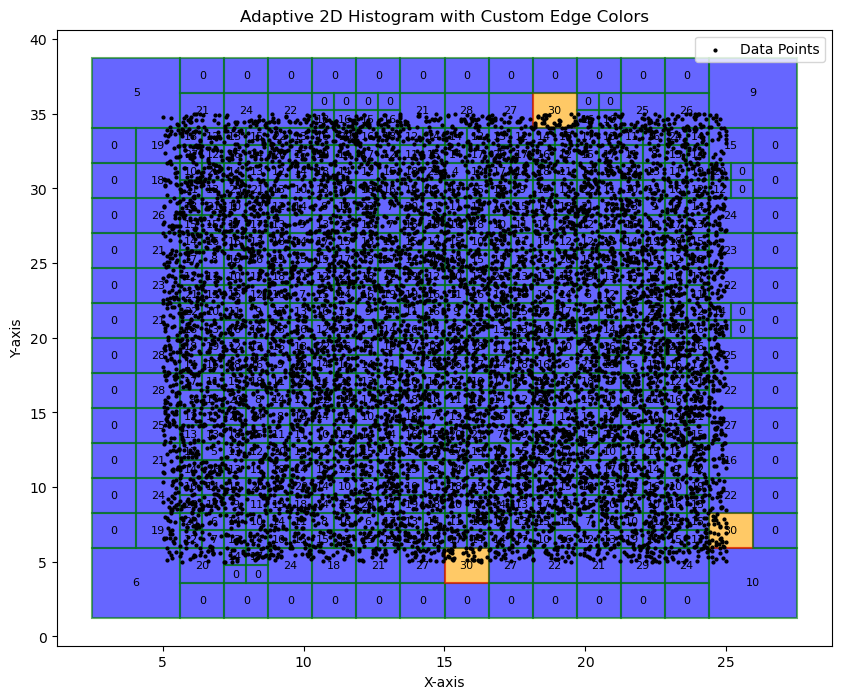

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function definitions here...

# Generate random data
np.random.seed(42)
x = np.random.uniform(25, 5, 10000)
np.random.seed(41)
y = np.random.uniform(35, 5, 10000)

# Compute the adaptive histogram with density disabled for count-based coloring
num, xmin, xmax, ymin, ymax = qthist(x, y, N=8, thresh=30, density=False)

# Convert to arrays to facilitate handling
xmin = np.array(xmin)
xmax = np.array(xmax)
ymin = np.array(ymin)
ymax = np.array(ymax)
num = np.array(num)

# Ensure arrays have consistent lengths
assert len(xmin) == len(xmax) == len(ymin) == len(ymax) == len(num), "Array lengths are inconsistent!"

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each bin as a rectangle with color and edge adjustments based on counts
for xmin_val, xmax_val, ymin_val, ymax_val, count in zip(xmin, xmax, ymin, ymax, num):
    # Set the fill color and edge color based on count
    if count < 30:
        color = 'blue'
        edge_color = 'green'
    elif count == 0:
        color = 'yellow'
        edge_color='white'
    else:
        color = 'orange'
        edge_color = 'red'

    # Add a rectangle for each bin
    rect = Rectangle((xmin_val, ymin_val), xmax_val - xmin_val, ymax_val - ymin_val,
                     linewidth=1.5, edgecolor=edge_color, facecolor=color, alpha=0.6)
    ax.add_patch(rect)

    # Annotate the bin with the count value in the center
    ax.text((xmin_val + xmax_val) / 2, (ymin_val + ymax_val) / 2, str(int(count)),
            ha='center', va='center', fontsize=8, color='black')

# Scatter plot overlay for reference points
ax.scatter(x, y, color='black', s=4, label='Data Points')

# Set plot labels and title
ax.set_title("Adaptive 2D Histogram with Custom Edge Colors")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.legend()

plt.show()


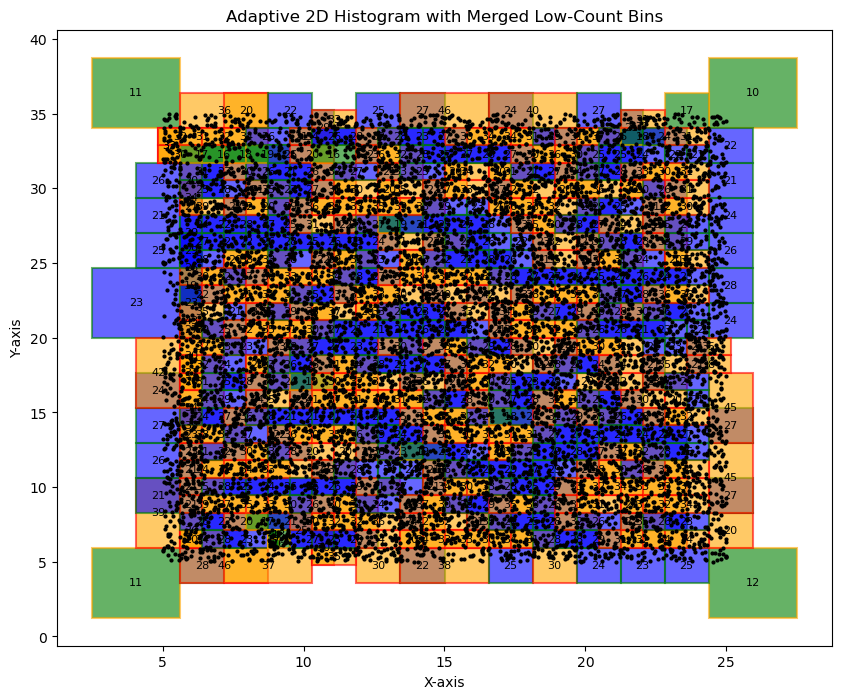

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assuming qthist function is already defined as provided.

# Generate random data
np.random.seed(42)
x = np.random.uniform(25, 5, 10000)
np.random.seed(39)
y = np.random.uniform(35, 5, 10000)

# Compute the adaptive histogram with density disabled for count-based merging
num, xmin, xmax, ymin, ymax = qthist(x, y, N=8, thresh=30, density=False)

# Convert outputs to arrays
xmin = np.array(xmin)
xmax = np.array(xmax)
ymin = np.array(ymin)
ymax = np.array(ymax)
num = np.array(num)

# Define a threshold for merging
low_count_threshold = 20

# Initialize lists to store merged bin information
merged_num = []
merged_xmin = []
merged_xmax = []
merged_ymin = []
merged_ymax = []

# Iterate over bins and apply merging criteria
for i in range(len(num)):
    if num[i] == 0:
        continue  # Ignore empty bins
    
    # Check if bin has a low count and should be merged
    if num[i] < low_count_threshold:
        # Check adjacent bins to find low-count neighbors
        merged = False
        
        for j in range(len(num)):
            # Skip if looking at the same bin or if the adjacent bin has zero count
            if i == j or num[j] == 0:
                continue
            
            # Check if bins are adjacent horizontally or vertically
            if (xmin[i] == xmax[j] or xmax[i] == xmin[j]) and ymin[i] == ymin[j] and ymax[i] == ymax[j]:
                # Horizontal merge
                merged_num.append(num[i] + num[j])
                merged_xmin.append(min(xmin[i], xmin[j]))
                merged_xmax.append(max(xmax[i], xmax[j]))
                merged_ymin.append(ymin[i])
                merged_ymax.append(ymax[i])
                merged = True
                break
            elif (ymin[i] == ymax[j] or ymax[i] == ymin[j]) and xmin[i] == xmin[j] and xmax[i] == xmax[j]:
                # Vertical merge
                merged_num.append(num[i] + num[j])
                merged_xmin.append(xmin[i])
                merged_xmax.append(xmax[i])
                merged_ymin.append(min(ymin[i], ymin[j]))
                merged_ymax.append(max(ymax[i], ymax[j]))
                merged = True
                break
        
        # If no adjacent low-count bins are found, keep the original bin
        if not merged:
            merged_num.append(num[i])
            merged_xmin.append(xmin[i])
            merged_xmax.append(xmax[i])
            merged_ymin.append(ymin[i])
            merged_ymax.append(ymax[i])
    else:
        # Keep bins that are already above the low count threshold
        merged_num.append(num[i])
        merged_xmin.append(xmin[i])
        merged_xmax.append(xmax[i])
        merged_ymin.append(ymin[i])
        merged_ymax.append(ymax[i])

# Convert merged bins to numpy arrays for consistency
merged_num = np.array(merged_num)
merged_xmin = np.array(merged_xmin)
merged_xmax = np.array(merged_xmax)
merged_ymin = np.array(merged_ymin)
merged_ymax = np.array(merged_ymax)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each merged bin with color coding based on counts
for xmin_val, xmax_val, ymin_val, ymax_val, count in zip(merged_xmin, merged_xmax, merged_ymin, merged_ymax, merged_num):    
    if 20 <count <30:
        color = 'blue'
        edge_color = 'green'
    elif count == 0:
        color = 'yellow'
        edge_color='white'
    elif count <20:
        color='green'
        edge_color='orange'
    else:
        color = 'orange'
        edge_color = 'red'
    
    # Draw rectangle for the merged bin
    rect = Rectangle((xmin_val, ymin_val), xmax_val - xmin_val, ymax_val - ymin_val,
                     linewidth=1.5, edgecolor=edge_color, facecolor=color, alpha=0.6)
    ax.add_patch(rect)
    
    # Annotate bin with the count
    ax.text((xmin_val + xmax_val) / 2, (ymin_val + ymax_val) / 2, str(int(count)),
            ha='center', va='center', fontsize=8, color='black')

# Scatter plot overlay for data points
ax.scatter(x, y, color='black', s=4, label='Data Points')

# Set plot labels and title
ax.set_title("Adaptive 2D Histogram with Merged Low-Count Bins")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
#ax.legend()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assuming qthist function is already defined

# Generate random data
np.random.seed(42)
x = np.random.uniform(25, 5, 10000)
np.random.seed(39)
y = np.random.uniform(35, 5, 10000)

# Compute the adaptive histogram with density disabled for count-based merging
num, xmin, xmax, ymin, ymax = qthist(x, y, N=8, thresh=30, density=False)

# Convert outputs to arrays
xmin = np.array(xmin)
xmax = np.array(xmax)
ymin = np.array(ymin)
ymax = np.array(ymax)
num = np.array(num)

# Define a threshold for merging
low_count_threshold = 20

# Initialize lists to store merged bin information
merged_num = []
merged_xmin = []
merged_xmax = []
merged_ymin = []
merged_ymax = []

# Iterate over bins and apply merging criteria
for i in range(len(num)):
    if num[i] == 0:
        continue  # Ignore empty bins
    
    # Check if bin has a low count and should be merged
    if num[i] < low_count_threshold:
        merged = False
        
        for j in range(len(num)):
            if i == j or num[j] == 0:
                continue
            
            # Check if bins are adjacent horizontally or vertically
            if (xmin[i] == xmax[j] or xmax[i] == xmin[j]) and ymin[i] == ymin[j] and ymax[i] == ymax[j]:
                merged_num.append(num[i] + num[j])
                merged_xmin.append(min(xmin[i], xmin[j]))
                merged_xmax.append(max(xmax[i], xmax[j]))
                merged_ymin.append(ymin[i])
                merged_ymax.append(ymax[i])
                merged = True
                break
            elif (ymin[i] == ymax[j] or ymax[i] == ymin[j]) and xmin[i] == xmin[j] and xmax[i] == xmax[j]:
                merged_num.append(num[i] + num[j])
                merged_xmin.append(xmin[i])
                merged_xmax.append(xmax[i])
                merged_ymin.append(min(ymin[i], ymin[j]))
                merged_ymax.append(max(ymax[i], ymax[j]))
                merged = True
                break
        
        # If no adjacent low-count bins are found, keep the original bin
        if not merged:
            merged_num.append(num[i])
            merged_xmin.append(xmin[i])
            merged_xmax.append(xmax[i])
            merged_ymin.append(ymin[i])
            merged_ymax.append(ymax[i])
    else:
        merged_num.append(num[i])
        merged_xmin.append(xmin[i])
        merged_xmax.append(xmax[i])
        merged_ymin.append(ymin[i])
        merged_ymax.append(ymax[i])

# Convert merged bins to numpy arrays for consistency
merged_num = np.array(merged_num)
merged_xmin = np.array(merged_xmin)
merged_xmax = np.array(merged_xmax)
merged_ymin = np.array(merged_ymin)
merged_ymax = np.array(merged_ymax)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each merged bin with color coding based on counts
for xmin_val, xmax_val, ymin_val, ymax_val, count in zip(merged_xmin, merged_xmax, merged_ymin, merged_ymax, merged_num):
    if 20 < count < 30:
        color = 'blue'
        edge_color = 'green'
    elif count == 0:
        color = 'yellow'
        edge_color = 'white'
    elif count < 20:
        color = 'green'
        edge_color = 'orange'
    else:
        color = 'orange'
        edge_color = 'red'
    
    # Draw rectangle for the merged bin
    rect = Rectangle((xmin_val, ymin_val), xmax_val - xmin_val, ymax_val - ymin_val,
                     linewidth=1.5, edgecolor=edge_color, facecolor=color, alpha=0.6)
    ax.add_patch(rect)

# Scatter plot overlay for data points
ax.scatter(x, y, color='black', s=4, label='Data Points')

# Set plot labels and title
ax.set_title("Adaptive 2D Histogram with Merged Low-Count Bins")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()
